## 目標：利用CNN 和 SVM等模型 預測未來3日波動度 > 1.5%
## Y: 1=>大於 0=>小於

## 載入Library

In [2]:
%pylab inline
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## 資料載入 and 重新設定Header

In [3]:
df = pd.read_excel('data.xlsx', sheetname="Data002", header=None)

df.columns = ['日期', '月線差1','月線差2', '月線差3','月線差4', '月線差5', '月線差6','月線差7', '月線差8', \
              '月線差9', '月線差10', '季線差1', '季線差2','季線差3', '季線差4','季線差5', '季線差6','季線差7', \
              '季線差8','季線差9', '季線差10', 'DIF差1', 'DIF差2','DIF差3', 'DIF差4','DIF差5', 'DIF差6', \
              'DIF差7', 'DIF差8','DIF差9', 'DIF差10', '最高-最低', '最高-最低1','最高-最低2', '最高-最低3', \
              '最高-最低4', '最高-最低5','最高-最低6', '最高-最低7','最高-最低8', '最高-最低9', '指數漲跌差1', \
              '指數漲跌差2', '指數漲跌差3','指數漲跌差4', '指數漲跌差5','指數漲跌差6', '指數漲跌差7','指數漲跌差8', \
              '指數漲跌差9','指數漲跌差10','指數收開差1','指數收開差2','指數收開差3','指數收開差4','指數收開差5', \
              '指數收開差6','指數收開差7','指數收開差8','指數收開差9','指數收開差10','Close','波動度','Y']

df = df[df['波動度'] != 100] # 去除末端資料
df.tail()

,日期,月線差1,月線差2,月線差3,月線差4,月線差5,月線差6,月線差7,月線差8,月線差9,...,指數收開差4,指數收開差5,指數收開差6,指數收開差7,指數收開差8,指數收開差9,指數收開差10,Close,波動度,Y
4075,2017-12-13,-9.40,-22.05,-32.70,-49.30,-67.15,-88.20,-100.80,-106.90,-116.10,...,6,-20,-156,-27,48,-1,-74,10450,0.488038,0
4076,2017-12-14,-4.50,-13.90,-26.55,-37.20,-53.80,-71.65,-92.70,-105.30,-111.40,...,63,6,-20,-156,-27,48,-1,10527,0.664957,0
4077,2017-12-15,-10.90,-15.40,-24.80,-37.45,-48.10,-64.70,-82.55,-103.60,-116.20,...,-63,63,6,-20,-156,-27,48,10485,0.114449,0
4078,2017-12-18,-8.25,-19.15,-23.65,-33.05,-45.70,-56.35,-72.95,-90.80,-111.85,...,17,-63,63,6,-20,-156,-27,10501,0.057137,0
4079,2017-12-19,-16.40,-24.65,-35.55,-40.05,-49.45,-62.10,-72.75,-89.35,-107.20,...,17,17,-63,63,6,-20,-156,10457,0.726786,0


## X Y 資料確認

In [4]:
pd.value_counts(df['Y'].values, sort=False) # 統計 0 and 1 的數量

0    2319
1    1761
dtype: int64

In [5]:
y = df['Y']
X = df.iloc[:,1:61]
X.head()

,月線差1,月線差2,月線差3,月線差4,月線差5,月線差6,月線差7,月線差8,月線差9,月線差10,...,指數收開差1,指數收開差2,指數收開差3,指數收開差4,指數收開差5,指數收開差6,指數收開差7,指數收開差8,指數收開差9,指數收開差10
0,-16.20,5038.50,5038.50,5038.50,5038.50,5038.50,5038.50,5038.50,5038.50,5038.50,...,-52,-60,40,11,-51,91,-134,-25,-89,-34
1,-22.55,-38.75,5015.95,5015.95,5015.95,5015.95,5015.95,5015.95,5015.95,5015.95,...,2,-52,-60,40,11,-51,91,-134,-25,-89
2,-19.45,-42.00,-58.20,4996.50,4996.50,4996.50,4996.50,4996.50,4996.50,4996.50,...,48,2,-52,-60,40,11,-51,91,-134,-25
3,-25.95,-45.40,-67.95,-84.15,4970.55,4970.55,4970.55,4970.55,4970.55,4970.55,...,-25,48,2,-52,-60,40,11,-51,91,-134
4,-31.05,-57.00,-76.45,-99.00,-115.20,4939.50,4939.50,4939.50,4939.50,4939.50,...,-53,-25,48,2,-52,-60,40,11,-51,91


In [6]:
type(y)

pandas.core.series.Series

In [7]:
y.shape

(4080,)

## 訓練資料 and 測試資料

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
X_train.shape

(3264, 60)

In [10]:
X_test.shape

(816, 60)

In [11]:
y_train.shape

(3264,)

In [12]:
y_test.shape

(816,)

## 尺度標準化

In [13]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train

array([[ 0.56648497,  0.27157785,  0.33392791, ...,  0.10824579,
        -0.05069415,  0.1013163 ],
       [ 0.40309185,  0.23042265,  0.21621006, ..., -0.28268947,
         0.86797645,  0.29558458],
       [-0.41867939, -0.16621063, -0.12246233, ...,  0.60343045,
         0.22490703,  0.04951143],
       ..., 
       [ 1.96493779,  0.91102684,  1.35648494, ..., -0.08722184,
        -0.260676  ,  0.8783894 ],
       [ 0.30457542,  0.09358159,  0.16108821, ..., -0.69968707,
        -0.10318961, -1.28446406],
       [ 0.56167929,  0.22887933,  0.20499884, ...,  0.17340166,
        -0.62814424,  0.14016996]])

In [14]:
X_test = sc.transform(X_test)
X_test

array([[  9.70162071e-01,   4.11505549e-01,   5.64692265e-01, ...,
          1.09861510e+00,   1.80131490e-03,  -1.52446632e-02],
       [ -9.42960068e-02,  -7.77269433e-02,  -1.56095997e-01, ...,
          3.94931642e-01,  -1.29437342e-01,  -3.13122684e-01],
       [  6.07333245e-01,   3.22507419e-01,   5.62823728e-01, ...,
         -8.29998825e-01,  -4.96905580e-01,  -1.02543969e+00],
       ..., 
       [ -2.72106160e-01,  -7.51547431e-02,  -2.65405429e-01, ...,
         -1.37730818e+00,   4.60827816e+00,   1.61660884e+00],
       [ -5.82072507e-01,  -2.99965047e-01,  -4.48522084e-01, ...,
         -4.65125920e-01,   9.20471911e-01,   7.54138650e-02],
       [  6.96238322e-01,   2.48428051e-01,   2.60587820e-01, ...,
          4.86149869e-01,  -6.54391968e-01,   1.01316302e-01]])

## 訓練ANN

In [15]:
X_train.shape

(3264, 60)

In [16]:
classifier = Sequential()

classifier.add(Dense(units = 31, kernel_initializer = 'uniform', activation = 'relu', input_dim = 60))
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 31))
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


In [17]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 200)

Epoch 1/500
3264/3264 [==============================] - 0s - loss: 0.6692 - acc: 0.5634     
Epoch 2/500
3264/3264 [==============================] - 0s - loss: 0.6484 - acc: 0.6449     
Epoch 3/500
3264/3264 [==============================] - 0s - loss: 0.6425 - acc: 0.6667     
Epoch 4/500
3264/3264 [==============================] - 0s - loss: 0.6369 - acc: 0.6716     
Epoch 5/500
3264/3264 [==============================] - 0s - loss: 0.6321 - acc: 0.6661     
Epoch 6/500
3264/3264 [==============================] - 0s - loss: 0.6285 - acc: 0.6737     
Epoch 7/500
3264/3264 [==============================] - 0s - loss: 0.6242 - acc: 0.6765     
Epoch 8/500
3264/3264 [==============================] - 0s - loss: 0.6210 - acc: 0.6792     
Epoch 9/500
3264/3264 [==============================] - 0s - loss: 0.6176 - acc: 0.6743     
Epoch 10/500
3264/3264 [==============================] - 0s - loss: 0.6136 - acc: 0.6820     
Epoch 11/500
3264/3264 [==============================] - 0

3264/3264 [==============================] - 0s - loss: 0.4294 - acc: 0.8024     
Epoch 88/500
3264/3264 [==============================] - 0s - loss: 0.4268 - acc: 0.8143     
Epoch 89/500
3264/3264 [==============================] - 0s - loss: 0.4229 - acc: 0.8097     
Epoch 90/500
3264/3264 [==============================] - 0s - loss: 0.4359 - acc: 0.8039     
Epoch 91/500
3264/3264 [==============================] - 0s - loss: 0.4257 - acc: 0.8128     
Epoch 92/500
3264/3264 [==============================] - 0s - loss: 0.4234 - acc: 0.8116     
Epoch 93/500
3264/3264 [==============================] - 0s - loss: 0.4233 - acc: 0.8091     
Epoch 94/500
3264/3264 [==============================] - 0s - loss: 0.4205 - acc: 0.8143     
Epoch 95/500
3264/3264 [==============================] - 0s - loss: 0.4147 - acc: 0.8162     
Epoch 96/500
3264/3264 [==============================] - 0s - loss: 0.4147 - acc: 0.8125     
Epoch 97/500
3264/3264 [==============================] - 0s - 

3264/3264 [==============================] - 0s - loss: 0.3281 - acc: 0.8588     
Epoch 173/500
3264/3264 [==============================] - 0s - loss: 0.3121 - acc: 0.8643     
Epoch 174/500
3264/3264 [==============================] - 0s - loss: 0.3246 - acc: 0.8615     
Epoch 175/500
3264/3264 [==============================] - 0s - loss: 0.3364 - acc: 0.8548     
Epoch 176/500
3264/3264 [==============================] - 0s - loss: 0.3217 - acc: 0.8634     
Epoch 177/500
3264/3264 [==============================] - 0s - loss: 0.3192 - acc: 0.8670     
Epoch 178/500
3264/3264 [==============================] - 0s - loss: 0.3182 - acc: 0.8603     
Epoch 179/500
3264/3264 [==============================] - 0s - loss: 0.3088 - acc: 0.8704     
Epoch 180/500
3264/3264 [==============================] - 0s - loss: 0.3098 - acc: 0.8673     
Epoch 181/500
3264/3264 [==============================] - 0s - loss: 0.3333 - acc: 0.8572     
Epoch 182/500
3264/3264 [=============================

3264/3264 [==============================] - 0s - loss: 0.2877 - acc: 0.8768     
Epoch 258/500
3264/3264 [==============================] - 0s - loss: 0.2760 - acc: 0.8833     
Epoch 259/500
3264/3264 [==============================] - 0s - loss: 0.2593 - acc: 0.8903     
Epoch 260/500
3264/3264 [==============================] - 0s - loss: 0.2581 - acc: 0.8909     
Epoch 261/500
3264/3264 [==============================] - 0s - loss: 0.3096 - acc: 0.8722     
Epoch 262/500
3264/3264 [==============================] - 0s - loss: 0.2622 - acc: 0.8873     
Epoch 263/500
3264/3264 [==============================] - 0s - loss: 0.2528 - acc: 0.8922     
Epoch 264/500
3264/3264 [==============================] - 0s - loss: 0.2475 - acc: 0.8983     
Epoch 265/500
3264/3264 [==============================] - 0s - loss: 0.2635 - acc: 0.8876     
Epoch 266/500
3264/3264 [==============================] - 0s - loss: 0.2485 - acc: 0.8949     
Epoch 267/500
3264/3264 [=============================

3264/3264 [==============================] - 0s - loss: 0.2214 - acc: 0.9075     
Epoch 343/500
3264/3264 [==============================] - 0s - loss: 0.2297 - acc: 0.9047     
Epoch 344/500
3264/3264 [==============================] - 0s - loss: 0.2337 - acc: 0.9053     
Epoch 345/500
3264/3264 [==============================] - 0s - loss: 0.2555 - acc: 0.8934     
Epoch 346/500
3264/3264 [==============================] - 0s - loss: 0.2324 - acc: 0.9026     
Epoch 347/500
3264/3264 [==============================] - 0s - loss: 0.2632 - acc: 0.8928     
Epoch 348/500
3264/3264 [==============================] - 0s - loss: 0.2554 - acc: 0.8922     
Epoch 349/500
3264/3264 [==============================] - 0s - loss: 0.2566 - acc: 0.8949     
Epoch 350/500
3264/3264 [==============================] - 0s - loss: 0.2341 - acc: 0.9032     
Epoch 351/500
3264/3264 [==============================] - 0s - loss: 0.2739 - acc: 0.8863     
Epoch 352/500
3264/3264 [=============================

3264/3264 [==============================] - 0s - loss: 0.2109 - acc: 0.9105     
Epoch 428/500
3264/3264 [==============================] - 0s - loss: 0.2169 - acc: 0.9105     
Epoch 429/500
3264/3264 [==============================] - 0s - loss: 0.2151 - acc: 0.9105     
Epoch 430/500
3264/3264 [==============================] - 0s - loss: 0.2628 - acc: 0.8915     
Epoch 431/500
3264/3264 [==============================] - 0s - loss: 0.2383 - acc: 0.9010     
Epoch 432/500
3264/3264 [==============================] - 0s - loss: 0.2355 - acc: 0.9010     
Epoch 433/500
3264/3264 [==============================] - 0s - loss: 0.2068 - acc: 0.9139     
Epoch 434/500
3264/3264 [==============================] - 0s - loss: 0.2022 - acc: 0.9164     
Epoch 435/500
3264/3264 [==============================] - 0s - loss: 0.2305 - acc: 0.9050     
Epoch 436/500
3264/3264 [==============================] - 0s - loss: 0.2358 - acc: 0.8989     
Epoch 437/500
3264/3264 [=============================

## 預測與驗證模型

In [18]:
y_pred = classifier.predict(X_test)

In [19]:
y_pred

array([[  5.82554435e-07],
       [  7.71262288e-01],
       [  1.00000000e+00],
       [  7.71262288e-01],
       [  6.40661836e-01],
       [  2.34993256e-20],
       [  3.13900324e-04],
       [  7.71262288e-01],
       [  8.79130149e-16],
       [  1.25078693e-01],
       [  3.21823987e-03],
       [  7.71262288e-01],
       [  7.71262288e-01],
       [  1.11495979e-01],
       [  1.53265195e-02],
       [  7.71262288e-01],
       [  1.11456026e-14],
       [  1.67112812e-04],
       [  7.71262288e-01],
       [  7.71262288e-01],
       [  8.87011051e-01],
       [  4.37363013e-07],
       [  7.71262288e-01],
       [  1.51754969e-19],
       [  8.03092420e-01],
       [  1.20045870e-05],
       [  1.97453512e-04],
       [  7.71262288e-01],
       [  1.67731023e-14],
       [  7.71262288e-01],
       [  7.71262288e-01],
       [  1.85247347e-01],
       [  7.71262288e-01],
       [  7.71262288e-01],
       [  7.71262288e-01],
       [  3.89516836e-16],
       [  2.08424986e-38],
 

In [21]:
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [

In [22]:
sum(y_pred.flatten().astype(int) == y_test) / len(y_test)

0.60539215686274506

In [23]:
cm = confusion_matrix(y_test, y_pred )
cm

array([[283, 195],
       [127, 211]])

## 繪製ANN 的 ROC Curve

In [24]:
y_pred = classifier.predict(X_test)
predicted = (y_pred > 0.5).flatten().astype(int)

In [25]:
predicted

array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0,

In [26]:
confusion_matrix(y_test, predicted)

array([[283, 195],
       [127, 211]])

In [27]:
fpr_ary, tpr_ary, thresholds = roc_curve(y_test, y_pred)

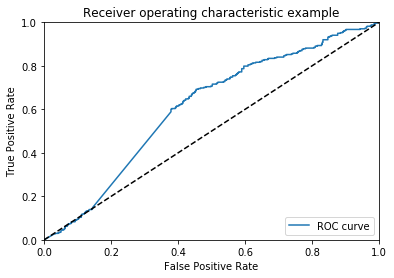

In [28]:
plt.plot(fpr_ary, tpr_ary, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 比較不同分類器準確度

In [29]:
# ANN
classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf1 = DecisionTreeClassifier()
clf1.fit(X_train, y_train)

clf2 = SVC(probability = True)
clf2.fit(X_train, y_train)

clf3 = LogisticRegression()
clf3.fit(X_train, y_train)

clf4 = RandomForestClassifier()
clf4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

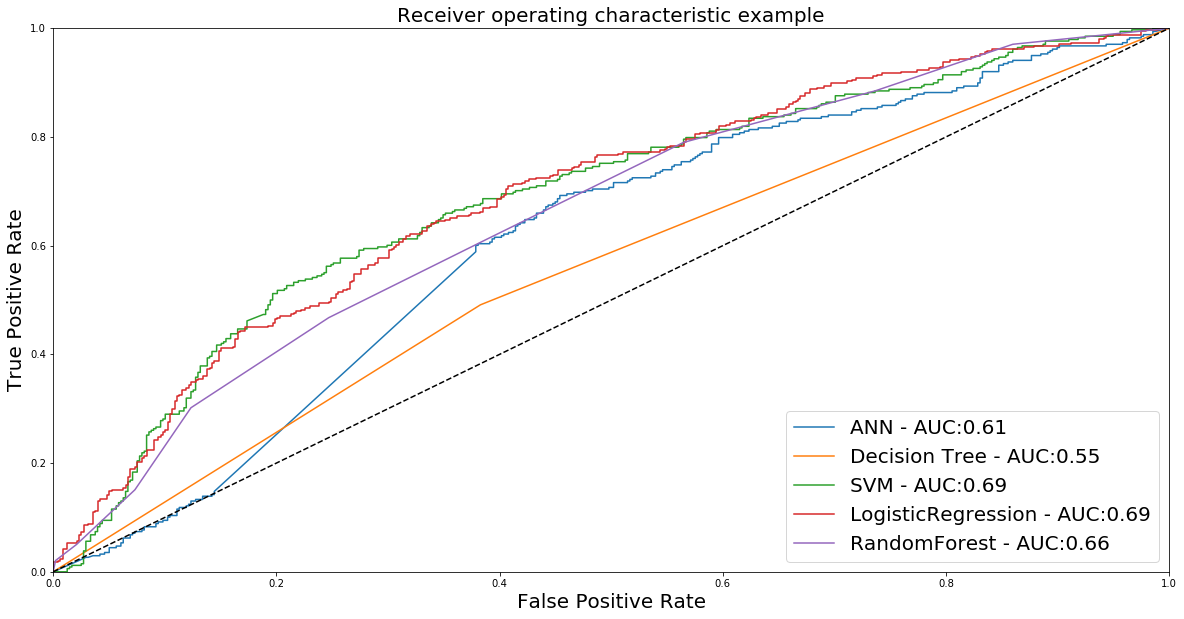

In [31]:
from sklearn.metrics import auc
plt.figure(figsize= [20,10])
for clf, title in zip([classifier,clf1,clf2,clf3, clf4], ['ANN','Decision Tree', 'SVM', 'LogisticRegression', 'RandomForest']):
    if title != 'ANN':
        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    else:
        y_pred = clf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='%s - AUC:%.2f'%(title, auc(fpr, tpr)) )
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver operating characteristic example', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.show()